<a href="https://colab.research.google.com/github/tamakoma1129/Synthesizer-Sound-Classification-with-SVM/blob/main/Synth%E3%81%AE%E5%88%86%E9%A1%9E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SVMでの実装

Accuracy:  0.5303030303030303
Accuracy:  0.553030303030303
Accuracy:  0.4772727272727273
Accuracy:  0.5454545454545454
Accuracy:  0.5833333333333334
Accuracy:  0.5681818181818182
Accuracy:  0.553030303030303
Accuracy:  0.5454545454545454
Accuracy:  0.5
Accuracy:  0.5
Accuracy:  0.5151515151515151
Accuracy:  0.5303030303030303
Accuracy:  0.5378787878787878
Accuracy:  0.5303030303030303
Accuracy:  0.45454545454545453
Accuracy:  0.4772727272727273
Accuracy:  0.5757575757575758
Accuracy:  0.5378787878787878
Accuracy:  0.5
Accuracy:  0.5378787878787878
Accuracy:  0.5303030303030303
Accuracy:  0.5151515151515151
Accuracy:  0.5833333333333334
Accuracy:  0.553030303030303
Accuracy:  0.5681818181818182
Accuracy:  0.49242424242424243
Accuracy:  0.5151515151515151
Accuracy:  0.6060606060606061
Accuracy:  0.553030303030303
Accuracy:  0.5075757575757576
Accuracy:  0.4772727272727273
Accuracy:  0.5681818181818182
Accuracy:  0.5606060606060606
Accuracy:  0.5378787878787878
Accuracy:  0.59090909090909

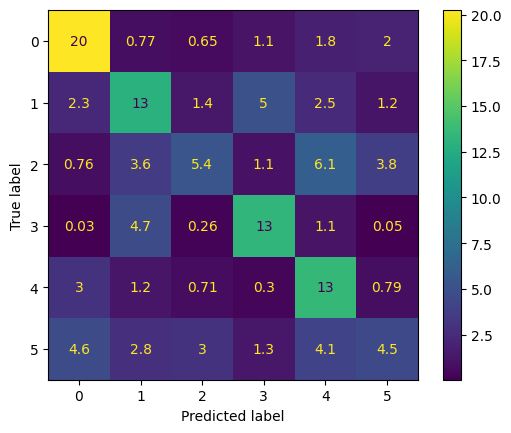

0:Bass
1:FX
2:Leads
3:Pads
4:Plucks
5:Stabs


In [7]:
import os
import glob
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import librosa
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random

max_length = int(44100 * 2)  # 今回は3秒でパディングするので、44100Hz*3

def load_and_pad(file_path):
    y, sr = librosa.load(file_path, sr=None)
    if len(y) > max_length:
        y = y[:max_length]  # もし長ければ切る
    else:
        y = np.pad(y, (0, max_length - len(y)))  # もし短ければ増やす
    return y

# フォルダ名とそのラベルを格納するリスト
data = []
labels = []

# フォルダのパスを指定します (e.g., "/content/drive/My Drive/A/data/")
base_folder_path = "/content/drive/MyDrive/シンセ音源分類ソフト作成/Data"

# フォルダ内のサブフォルダ（ジャンル）を一つひとつ見ていきます
for genre_folder in os.listdir(base_folder_path):
    # サブフォルダ内の全ての.wavファイルに対して処理を行います
    for filename in glob.glob(os.path.join(base_folder_path, genre_folder, '*.wav')):
        # 音声ファイルの読み込みとパディング
        y = load_and_pad(filename)
        # MFCCの計算
        mfccs = librosa.feature.mfcc(y=y, sr=44100, n_mfcc=40)
        data.append(mfccs.flatten())  # SVMの入力に合わせデータをフラット化します
        labels.append(genre_folder)  # フォルダ名（ジャンル名）をラベルとして追加

# ラベル（ジャンル名）を数値に変換します。例えば、'CHihat' -> 0, 'OHihat' -> 1のような変換を行います
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)

accuracy100 = 0
accuracy_list = []
cm100 = np.zeros((len(encoder.classes_), len(encoder.classes_)))
for _ in range(100):
  # データとラベルを訓練データとテストデータに分割します
  X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=random.randint(1,10000))

  # SVMのモデルを作成し、訓練データで学習します
  model = svm.SVC()
  model.fit(X_train, y_train)

  # テストデータでモデルの精度を確認します
  accuracy = model.score(X_test, y_test)
  accuracy_list.append(accuracy)
  print("Accuracy: ", accuracy)
  accuracy100+=accuracy
  # テストデータの予測値を得ます
  y_pred = model.predict(X_test)

  # 混同行列を計算し、加算します
  cm = confusion_matrix(y_test, y_pred)
  cm100 += cm


accuracy_std = np.std(accuracy_list)
print("標準偏差: ", accuracy_std)
print("平均正答率",accuracy100/100)
# 混同行列の平均を計算します
cm_avg = cm100 / 100


# 混同行列をプロットします
disp = ConfusionMatrixDisplay(confusion_matrix=cm_avg,display_labels=model.classes_)
disp.plot()
plt.show()
cnt=0
# 各ラベルに対応した名前を表示します
for i in encoder.classes_:
  print(f"{cnt}:{i}")
  cnt+=1

決定木での実装

ストリーミング出力は最後の 5000 行に切り捨てられました。
 [0.09473684 0.06315789 0.12631579 0.         0.58947368 0.12631579]
 [0.02439024 0.07317073 0.31707317 0.04878049 0.12195122 0.41463415]
 [0.09473684 0.06315789 0.12631579 0.         0.58947368 0.12631579]
 [0.02439024 0.07317073 0.31707317 0.04878049 0.12195122 0.41463415]
 [0.         0.03125    0.03125    0.9375     0.         0.        ]
 [0.         0.         0.         0.         0.         1.        ]
 [0.         0.         0.         0.         0.         1.        ]
 [0.09473684 0.06315789 0.12631579 0.         0.58947368 0.12631579]
 [0.         1.         0.         0.         0.         0.        ]
 [0.03333333 0.61666667 0.08333333 0.15       0.05       0.06666667]
 [0.         0.25925926 0.14814815 0.51851852 0.03703704 0.03703704]
 [0.09473684 0.06315789 0.12631579 0.         0.58947368 0.12631579]
 [0.03333333 0.61666667 0.08333333 0.15       0.05       0.06666667]
 [0.02439024 0.07317073 0.31707317 0.04878049 0.12195122 0.41463415]
 [

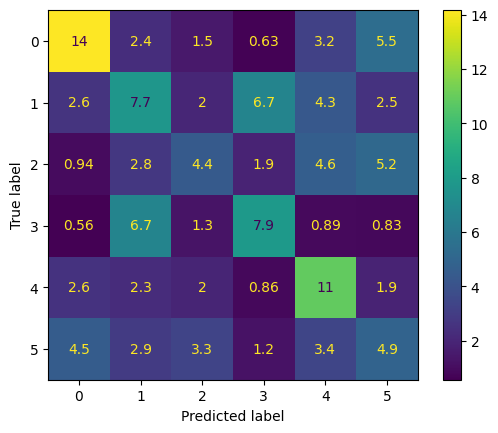

0:Bass
1:FX
2:Leads
3:Pads
4:Plucks
5:Stabs


In [4]:
import os
import glob
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import librosa
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random
from sklearn.tree import DecisionTreeClassifier

max_length = int(44100 * 2)  # 今回は3秒でパディングするので、44100Hz*3

def load_and_pad(file_path):
    y, sr = librosa.load(file_path, sr=None)
    if len(y) > max_length:
        y = y[:max_length]  # もし長ければ切る
    else:
        y = np.pad(y, (0, max_length - len(y)))  # もし短ければ増やす
    return y

# フォルダ名とそのラベルを格納するリスト
data = []
labels = []

# フォルダのパスを指定します (e.g., "/content/drive/My Drive/A/data/")
base_folder_path = "/content/drive/MyDrive/シンセ音源分類ソフト作成/Data"

# フォルダ内のサブフォルダ（ジャンル）を一つひとつ見ていきます
for genre_folder in os.listdir(base_folder_path):
    # サブフォルダ内の全ての.wavファイルに対して処理を行います
    for filename in glob.glob(os.path.join(base_folder_path, genre_folder, '*.wav')):
        # 音声ファイルの読み込みとパディング
        y = load_and_pad(filename)
        # MFCCの計算
        mfccs = librosa.feature.mfcc(y=y, sr=44100, n_mfcc=40)
        data.append(mfccs.flatten())  # SVMの入力に合わせデータをフラット化します
        labels.append(genre_folder)  # フォルダ名（ジャンル名）をラベルとして追加

# ラベル（ジャンル名）を数値に変換します。例えば、'CHihat' -> 0, 'OHihat' -> 1のような変換を行います
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)

accuracy100 = 0
accuracy_list = []
cm100 = np.zeros((len(encoder.classes_), len(encoder.classes_)))
for _ in range(100):
  # データとラベルを訓練データとテストデータに分割します
  X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=random.randint(1,10000))

  # SVMのモデルを作成し、訓練データで学習します
  model = DecisionTreeClassifier(max_depth=5)
  model.fit(X_train, y_train)

  # テストデータでモデルの精度を確認します
  accuracy = model.score(X_test, y_test)
  accuracy_list.append(accuracy)
  print("Accuracy: ", accuracy)
  accuracy100+=accuracy
  # テストデータの予測値を得ます
  y_pred = model.predict(X_test)
  # 各ジャンルに適している確率を得ます
  y_proba = model.predict_proba(X_test)
  print(y_proba,"○○が各ジャンルに適している確率")

  # 混同行列を計算し、加算します
  cm = confusion_matrix(y_test, y_pred)
  cm100 += cm


accuracy_std = np.std(accuracy_list)
print("標準偏差: ", accuracy_std)
print("平均正答率",accuracy100/100)
# 混同行列の平均を計算します
cm_avg = cm100 / 100


# 混同行列をプロットします
disp = ConfusionMatrixDisplay(confusion_matrix=cm_avg,display_labels=model.classes_)
disp.plot()
plt.show()
cnt=0
# 各ラベルに対応した名前を表示します
for i in encoder.classes_:
  print(f"{cnt}:{i}")
  cnt+=1

ランダムフォレスト

ストリーミング出力は最後の 5000 行に切り捨てられました。
 [0.06166667 0.27654762 0.22       0.0225     0.22095238 0.19833333]
 [0.01666667 0.125      0.46166667 0.115      0.11333333 0.16833333]
 [0.005      0.06       0.13       0.11       0.055      0.64      ]
 [0.07166667 0.18988095 0.20633333 0.04       0.25961905 0.2325    ]
 [0.44833333 0.19666667 0.02       0.08       0.135      0.12      ]
 [0.50809524 0.02       0.04       0.         0.32357143 0.10833333]
 [0.81366667 0.067      0.         0.02       0.01833333 0.081     ]
 [0.21       0.01       0.04       0.         0.0675     0.6725    ]
 [0.045      0.03       0.42       0.         0.19       0.315     ]
 [0.1477381  0.         0.         0.01       0.7797619  0.0625    ]
 [0.38083333 0.1425     0.12       0.06       0.16916667 0.1275    ]
 [0.025      0.16333333 0.13       0.14       0.44416667 0.0975    ]
 [0.06       0.065      0.16       0.         0.55       0.165     ]
 [0.01       0.11766667 0.078      0.72766667 0.01       0.05666667]
 [

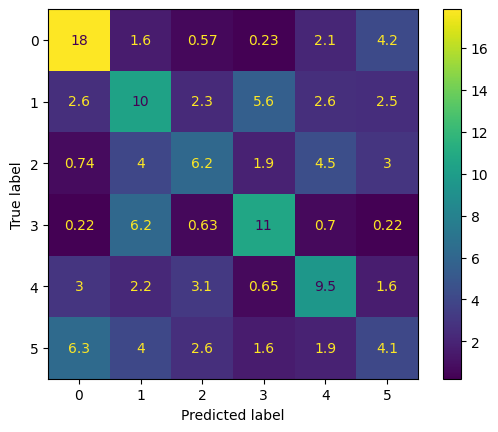

0:Bass
1:FX
2:Leads
3:Pads
4:Plucks
5:Stabs


In [5]:
import os
import glob
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import librosa
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random
from sklearn.ensemble import RandomForestClassifier#ランダムフォレスト

max_length = int(44100 * 2)  # 今回は3秒でパディングするので、44100Hz*3

def load_and_pad(file_path):
    y, sr = librosa.load(file_path, sr=None)
    if len(y) > max_length:
        y = y[:max_length]  # もし長ければ切る
    else:
        y = np.pad(y, (0, max_length - len(y)))  # もし短ければ増やす
    return y

# フォルダ名とそのラベルを格納するリスト
data = []
labels = []

# フォルダのパスを指定します (e.g., "/content/drive/My Drive/A/data/")
base_folder_path = "/content/drive/MyDrive/シンセ音源分類ソフト作成/Data"

# フォルダ内のサブフォルダ（ジャンル）を一つひとつ見ていきます
for genre_folder in os.listdir(base_folder_path):
    # サブフォルダ内の全ての.wavファイルに対して処理を行います
    for filename in glob.glob(os.path.join(base_folder_path, genre_folder, '*.wav')):
        # 音声ファイルの読み込みとパディング
        y = load_and_pad(filename)
        # MFCCの計算
        mfccs = librosa.feature.mfcc(y=y, sr=44100, n_mfcc=40)
        data.append(mfccs.flatten())  # SVMの入力に合わせデータをフラット化します
        labels.append(genre_folder)  # フォルダ名（ジャンル名）をラベルとして追加

# ラベル（ジャンル名）を数値に変換します。例えば、'CHihat' -> 0, 'OHihat' -> 1のような変換を行います
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)

accuracy100 = 0
accuracy_list = []
cm100 = np.zeros((len(encoder.classes_), len(encoder.classes_)))
for _ in range(100):
  # データとラベルを訓練データとテストデータに分割します
  X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=random.randint(1,10000))

  # SVMのモデルを作成し、訓練データで学習します
  model = RandomForestClassifier(random_state=random.randint(1,10000))
  model.fit(X_train, y_train)

  # テストデータでモデルの精度を確認します
  accuracy = model.score(X_test, y_test)
  accuracy_list.append(accuracy)
  print("Accuracy: ", accuracy)
  accuracy100+=accuracy
  # テストデータの予測値を得ます
  y_pred = model.predict(X_test)
  # 各ジャンルに適している確率を得ます
  y_proba = model.predict_proba(X_test)
  print(y_proba,"○○が各ジャンルに適している確率")

  # 混同行列を計算し、加算します
  cm = confusion_matrix(y_test, y_pred)
  cm100 += cm


accuracy_std = np.std(accuracy_list)
print("標準偏差: ", accuracy_std)
print("平均正答率",accuracy100/100)
# 混同行列の平均を計算します
cm_avg = cm100 / 100


# 混同行列をプロットします
disp = ConfusionMatrixDisplay(confusion_matrix=cm_avg,display_labels=model.classes_)
disp.plot()
plt.show()
cnt=0
# 各ラベルに対応した名前を表示します
for i in encoder.classes_:
  print(f"{cnt}:{i}")
  cnt+=1